# Support Vector Machine

These are some experiments with SVM. Here I test the 3 main SVC (Support Vector Classification) algorithms: Linear SVM, Nu-SVM and C-SVM. The N-SVM seems to be the best but we need more experiments.

This analysis is very simple. I shuffle my dataset and take $30\%$ of testing. I do this $M$ times and store each shuffled data set. Then I preform $M$ classifications and take the mean of thhe numer of miss-classified samples and corresponding variance.

This is only for a single cell (like Anabel did). I guess we should have to repeat this for all cells in the mesh.

In [1]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math #


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.svm import LinearSVC, NuSVC, SVC

In [2]:
# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

# Setup numpy options
np.set_printoptions(precision=3, suppress=True)

# Get the data
# PT_data = pd.read_excel("PTResults_trimmed.xlsx")
PT_data = pd.read_excel("PTResults.xlsx")
# PT_data = pd.read_excel("../../Data/PTResults_ice.xlsx")

### Training SVM

Here you can change the number of shuffles and test size. This will store the training and testing features and targets to be used for any algorithms you want.

In [3]:
## TRAINING SVM  ##


M = 1000 # number of shuffles
test_size = 15 # number of cells to be tested out of 100



data_matrix = np.asarray(PT_data)
X_aux = data_matrix[:,0:5]
X = []
y = []
n_loc = len(data_matrix[0,5:-1])
for i in range(5):
    for loc in range(7,n_loc):
        x = np.append(X_aux[i,:], loc-5)
        X.append(x)
        y.append(data_matrix[i,loc-5].astype(int))

training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []



#Splitting the data into training and testing and storing to reuze same seeds
# for the different algorithms
for i in range(M):
    
    #Splitting the data into training and testing
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=test_size/100, shuffle=True)

    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)


## Linear SVM

This uses the kernel $K(x,x') := \langle x, x'\rangle$. It's here just for fun. It gives very bad results...

In [4]:
# Linear Support Vector Classification
MSE_linear = 0
VarMSE_linear = 0
missclass = []
for i in range(M):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]
    #Training with Linear SVC
    model = LinearSVC(random_state=0, tol=1e-5)
    model.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = model.predict(testing_features)
    
    #Get means and std
    MSE = mean_squared_error(prediction, testing_target)
    MSE_linear += MSE
    VarMSE_linear += MSE*MSE
    missclass.append(test_size*mean_squared_error(prediction, testing_target))
    
MSE_linear /= M
VarMSE_linear -= M*MSE_linear**2
VarMSE_linear /=(M-1)
count_linear = test_size*MSE_linear
countstd_linear = test_size*VarMSE_linear
print('Average number of miss classified cells out of ' + str(M) + ' shuffles: ' + 
      str(count_linear) + ' +- ' + str(countstd_linear))

Average number of miss classified cells out of 1000 shuffles: 5.8930952381 +- 0.198391887731


## Nu-Support Vector Classification

See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html

We start by choosing the kernel: 'rbf' or 'poly'. 
    - If 'rbf' is choosen then we can choose two parameters: $\nu$ and $\gamma$
    - If 'poly' or 'sigmoid' is choosen then we can choose three parameters: $\nu$, $\gamma$ and polynomial degree

The values of the parameters to be tested are in: nu_vector, gamma_vector and degree_vector. You may change these values if you want. Be carefull, for dregree > 3 things become slow for $\gamma > 0.01$.

The strategy to find to optimum is to save all combinations of parameters that give $<15\%$ misclassification with variance $<5\%$. To do so we start with kernel = 'rbf' to tune the gamma values. We will see that the kernel = 'poly' is the best. 

#### Classifier function

This is our personalised classifier that returns the mean squared error, the variance of the MSE and the number of misclassified shuffles

In [5]:
# Nu-Support Vector Classification
def mySVC_Nu(nu, kernel, gamma, degree=0):

    MSE_Nu = 0
    VarMSE_Nu = 0
    missclass = []
    for i in range(M):
        
        training_features = training_features_vector[i]
        testing_features = testing_features_vector[i]
        training_target = training_target_vector[i]
        testing_target = testing_target_vector[i]

        #Training with Nu-SVC
        model = NuSVC(nu = nu, kernel = kernel, degree=degree, gamma=gamma)
            
        model.fit(training_features, training_target)

        #Comparing prediction with testing values
        prediction = model.predict(testing_features)

        #Get means and std
        MSE = mean_squared_error(prediction, testing_target)
        MSE_Nu += MSE
        VarMSE_Nu += MSE*MSE
        missclass.append(test_size*mean_squared_error(prediction, testing_target))

    MSE_Nu /= M
    VarMSE_Nu -= M*MSE_Nu**2
    VarMSE_Nu /=(M-1)
#     count_Nu = test_size*MSE_Nu
#     countVar_Nu = test_size*VarMSE_Nu
           
    return MSE_Nu, VarMSE_Nu, missclass

### kernel = 'rbf'

In [7]:
nu_vector = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
gamma_vector = [0.0001, 0.001, 0.01, 0.1]



# kernel = 'rbf'
opt_rbf = []
n_simul = len(nu_vector)*len(gamma_vector)
count = 0
for i in range(len(nu_vector)):
    nu = nu_vector[i]
    for j in range(len(gamma_vector)):
        count += 1
        if count % 10 == 0:
            print('# simulations done ' + str(count) + '/' + str(n_simul))
        gamma = gamma_vector[j]
        MSE, VarMSE, missclass = mySVC_Nu(nu=nu, kernel = 'rbf', gamma=gamma, degree=0)
        if test_size*MSE/test_size < 0.06 and test_size*VarMSE/test_size < 0.005:
            opt_rbf.append([i,j])

print('candidate indices for optimal distributions')                
print(opt_rbf)            

# simulations done 10/28
# simulations done 20/28
candidate indices for optimal distributions
[[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2], [6, 3]]


In [13]:
axes_vector = []
for i in range(len(opt_rbf)):
    nu = nu_vector[opt_rbf[i][0]]
    gamma = gamma_vector[opt_rbf[i][1]]
#     degree = degree_vector[opt_rbf[i][2]]
    MSE, VarMSE, missclass = mySVC_Nu(nu=nu, kernel = 'sigmoid', gamma=gamma, degree=0)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) +\
          r' with gamma = ' + str(gamma) +  r'and nu = ' + str(nu))

Average # misclassified samples from 15 samples: 7.03761904762 +- 0.127499517658 with gamma = 0.0001and nu = 0.1
Average # misclassified samples from 15 samples: 7.77630952381 +- 0.0249379755795 with gamma = 0.001and nu = 0.1
Average # misclassified samples from 15 samples: 7.77630952381 +- 0.0249379755795 with gamma = 0.01and nu = 0.1
Average # misclassified samples from 15 samples: 7.77630952381 +- 0.0249379755795 with gamma = 0.1and nu = 0.1
Average # misclassified samples from 15 samples: 6.99261904762 +- 0.119856587502 with gamma = 0.0001and nu = 0.15
Average # misclassified samples from 15 samples: 7.77630952381 +- 0.0249379755795 with gamma = 0.001and nu = 0.15
Average # misclassified samples from 15 samples: 7.77630952381 +- 0.0249379755795 with gamma = 0.01and nu = 0.15
Average # misclassified samples from 15 samples: 7.77630952381 +- 0.0249379755795 with gamma = 0.1and nu = 0.15
Average # misclassified samples from 15 samples: 6.99654761905 +- 0.110519210632 with gamma = 0.00

### kernel = 'sigmoid'

In [15]:
nu_vector = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [2,3,4]

# counting how many simulations to be done
n_simul_sigm = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            n_simul_sigm += 1

print('number of simulations to be done ' + str(n_simul_sigm))


# kernel = 'poly'
opt_sigm = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_sigm))
            nu = nu_vector[i]
            MSE, VarMSE, missclass = mySVC_Nu(nu=nu, kernel = 'sigmoid', gamma=gamma, degree=degree)
            if test_size*MSE/test_size < 0.06 and test_size*VarMSE/test_size < 0.005:
                opt_sigm.append([i,j,k])

print('candidate indices for optimal distributions')                
print(opt_sigm)  

number of simulations to be done 135
# simulations done 20/135
# simulations done 40/135
# simulations done 60/135
# simulations done 80/135
# simulations done 100/135
# simulations done 120/135
candidate indices for optimal distributions
[]


In [16]:
axes_vector = []
for i in range(len(opt_sigm)):
    nu = nu_vector[opt_sigm[i][0]]
    gamma = gamma_vector[opt_sigm[i][1]]
    degree = degree_vector[opt_sigm[i][2]]
    MSE, VarMSE, missclass = mySVC_Nu(nu, kernel = 'sigmoid', gamma=gamma, degree=degree)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and nu = ' + str(nu))

### kernel = 'poly'

In [20]:
nu_vector = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [2,3,4]

# counting how many simulations to be done
n_simul_poly = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            n_simul_poly += 1

print('number of simulations to be done ' + str(n_simul_poly))


# kernel = 'poly'
opt_poly = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_poly))
            nu = nu_vector[i]
            MSE, VarMSE, missclass = mySVC_Nu(nu=nu, kernel = 'poly', gamma=gamma, degree=degree)
            if test_size*MSE/test_size < 0.06 and test_size*VarMSE/test_size < 0.005:
                opt_poly.append([i,j,k])


                
print()                
print('candidate indices for optimal distributions')                
print(opt_poly)            

number of simulations to be done 63
# simulations done 20/63
# simulations done 40/63
# simulations done 60/63

candidate indices for optimal distributions
[[1, 1, 0], [0, 2, 0], [1, 2, 0], [0, 1, 1], [1, 1, 1], [2, 1, 1], [0, 1, 2], [1, 1, 2], [2, 1, 2]]


Simulate once again the candidates for optimum to get the histograms

In [21]:
axes_vector = []
for i in range(len(opt_poly)):
    nu = nu_vector[opt_poly[i][0]]
    gamma = gamma_vector[opt_poly[i][1]]
    degree = degree_vector[opt_poly[i][2]]
    MSE, VarMSE, missclass = mySVC_Nu(nu, kernel = 'poly', gamma=gamma, degree=degree)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and nu = ' + str(nu))

Average # misclassified samples from 15 samples: 0.649047619048 +- 0.00485906919769 with gamma = 0.0001, degree 2 and nu = 0.15
Average # misclassified samples from 15 samples: 0.7075 +- 0.0957512226891 with gamma = 0.001, degree 2 and nu = 0.1
Average # misclassified samples from 15 samples: 0.652380952381 +- 0.00484573764997 with gamma = 0.001, degree 2 and nu = 0.15
Average # misclassified samples from 15 samples: 0.742976190476 +- 0.00459730232878 with gamma = 0.0001, degree 3 and nu = 0.1
Average # misclassified samples from 15 samples: 0.679285714286 +- 0.0048135474855 with gamma = 0.0001, degree 3 and nu = 0.15
Average # misclassified samples from 15 samples: 0.897380952381 +- 0.00823627482358 with gamma = 0.0001, degree 3 and nu = 0.2
Average # misclassified samples from 15 samples: 0.570595238095 +- 0.00453982989036 with gamma = 0.0001, degree 4 and nu = 0.1
Average # misclassified samples from 15 samples: 0.692380952381 +- 0.00471951921687 with gamma = 0.0001, degree 4 and nu

Plotting histograms

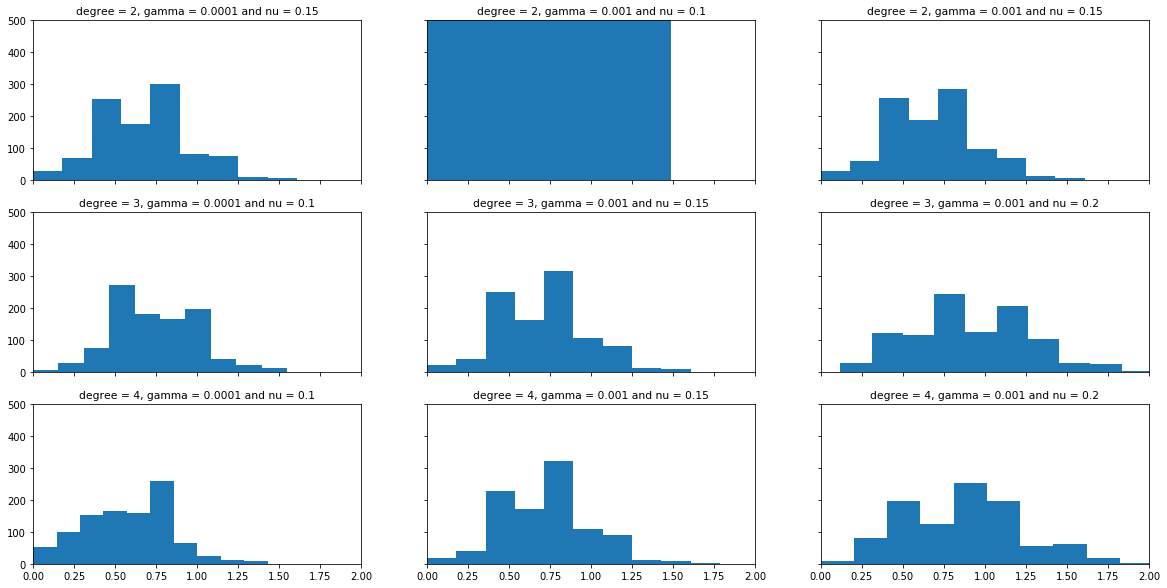

In [43]:
# Plotting for optimum
rows = 3
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(20,10), sharex='col', sharey='row')
plt.rcParams.update({'font.size': 9})

for i in range(rows):
    for j in range(columns):
        ax[i,j].hist(axes_vector[columns*i + j], bins=10)
        ax[i,j].set_title('degree = ' + str(degree_vector[opt_poly[columns*i + j][2]]) + ', gamma = ' + str (gamma_vector[opt_poly[j][1]]) \
                        + ' and nu = ' + str(nu_vector[opt_poly[columns*i + j][0]]))
        ax[i,j].set_ylim(0,500)
        ax[i,j].set_xlim(0,2)

plt.show()

## C-Support Vector Classification

see documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

Same as for Nu-SVC (very little changes). Parameter $\nu$ becomes the parameter C.

YOU CAN USE THE PARAMETERS YOU WANT BUT IT IS VERY UNLIKELY THERE WILL BE A CANDIDATE FOR OPTIMAL DISTRIBUTION. The mean may get low but variance is too large

In [ ]:
# C-Support Vector Classification
def mySVC(C, kernel, gamma, degree):  # changed the name of the function

    MSE_svc = 0
    VarMSE_svc = 0
    missclass = []
    for i in range(M):
        training_features = training_features_vector[i]
        testing_features = testing_features_vector[i]
        training_target = training_target_vector[i]
        testing_target = testing_target_vector[i]

        #Training with Nu-SVC
        model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
        model.fit(training_features, training_target)

        #Comparing prediction with testing values
        prediction = model.predict(testing_features)

        #Get means and std
        MSE = mean_squared_error(prediction, testing_target)
        MSE_svc += MSE
        VarMSE_svc += MSE*MSE
        missclass.append(test_size*mean_squared_error(prediction, testing_target))

    MSE_svc /= M
    VarMSE_svc -= M*MSE_svc**2
    VarMSE_svc/=(M-1)
    count_svc = test_size*MSE_svc
    countVar_svc = test_size*VarMSE_svc
    
           
    return MSE, VarMSE, missclass

### kernel = 'rbf'

In [ ]:
C_vector = [0.2, 0.4, 0.8, 1, 2, 5, 10]
gamma_vector = [0.0001, 0.001, 0.01, 0.1]

# kernel = 'rbf'
opt_rbf = []
n_simul = len(C_vector)*len(gamma_vector)
count = 0
for i in range(len(C_vector)):
    C = C_vector[i]
    for j in range(len(gamma_vector)):
        count += 1
        if count % 10 == 0:
            print('# simulations done ' + str(count) + '/' + str(n_simul))
        gamma = gamma_vector[j]
        MSE, VarMSE, missclass = mySVC(C=C, kernel = 'rbf', gamma=gamma, degree=0) # changed mySVC
        if test_size*MSE/test_size < 0.1 and test_size*VarMSE/test_size < 0.05:
            opt_rbf.append([i,j])

print()
if len(opt_rbf) == 0: print('no condidates for optimal distributions')
else:        
    print('candidate indices for optimal distributions')
    print(opt_rbf)           

In [ ]:
axes_vector = []
for i in range(len(opt_rbf)):
    C = C_vector[opt_rbf[i][0]]
    gamma = gamma_vector[opt_rbf[i][1]]
    MSE, VarMSE, missclass = mySVC(C, kernel = 'rbf', gamma=gamma, degree=0)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and C = ' + str(C))

### kernel = 'sigmoid'

In [ ]:
C_vector = [0.2, 0.4, 0.8, 1, 2, 5, 10]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [0,1,2,3,4]

# counting how many simulations to be done
n_simul_sigm = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            n_simul_sigm += 1

print('number of simulations to be done ' + str(n_simul_sigm))


# kernel = 'sigmoid'
opt_sigm = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_sigm))
            nu = nu_vector[i]
            MSE, VarMSE, missclass = mySVC(C=C, kernel = 'sigmoid', gamma=gamma, degree=degree)
            if test_size*MSE/test_size < 0.15 and test_size*VarMSE/test_size < 0.05:
                opt_sigm.append([i,j,k])

print()
if len(opt_sigm == 0: print('no condidates for optimal distributions')
else:        
    print('candidate indices for optimal distributions')
    print(opt_sigm) 

### kernel = 'poly'

In [ ]:
C_vector = [0.2, 0.4, 0.8, 1, 2, 5, 10]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [0,1,2,3,4]

# counting how many simulations to be done
n_simul_poly = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            n_simul_poly += 1

print('number of simulations to be done ' + str(n_simul_poly))


# kernel = 'poly'
opt_poly = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_poly))
            nu = nu_vector[i]
            MSE, VarMSE, missclass = mySVC(C=C, kernel = 'poly', gamma=gamma, degree=degree)
            if test_size*MSE/test_size < 0.15 and test_size*VarMSE/test_size < 0.05:
                opt_poly.append([i,j,k])


print()              
if len(opt_rbf) == 0: print('no condidates for optimal distributions')
else:        
    print('candidate indices for optimal distributions')
    print(opt_rbf) 




Simulate once again the candidates for optimum to get the histograms

In [ ]:
axes_vector = []
for i in range(len(opt_poly)):
    nu = nu_vector[opt_poly[i][0]]
    gamma = gamma_vector[opt_poly[i][1]]
    degree = degree_vector[opt_poly[i][2]]
    MSE, VarMSE, missclass = mySVC(C=C, kernel = 'poly', gamma=gamma, degree=degree)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and C = ' + str(C))

In [45]:
# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

# Setup numpy options
np.set_printoptions(precision=3, suppress=True)

# Get the data
# PT_data = pd.read_excel("PTResults_trimmed.xlsx")
# PT_data = pd.read_excel("PTResults.xlsx")
PT_data = pd.read_excel("PTResults_ice.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: 'PTResults_ice.xlsx'